# The so-called "test-set" in this file is actually valset

In [11]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm
import os
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
sr = 16000

In [12]:
dropout = 0.3
half = False

## EDA

Unnamed: 0                                                76969
anchor_speaker                                 Elizabeth_Arnold
anchor_file         trainfiles/start_segments/j960607aseg36.npy
positive_file         trainfiles/end_segments/j960521dseg21.npy
negative_speaker                                George_Lewinski
negative_file       trainfiles/start_segments/k960603_seg26.npy
Name: 76969, dtype: object
0.1352071562880415
(128, 598)


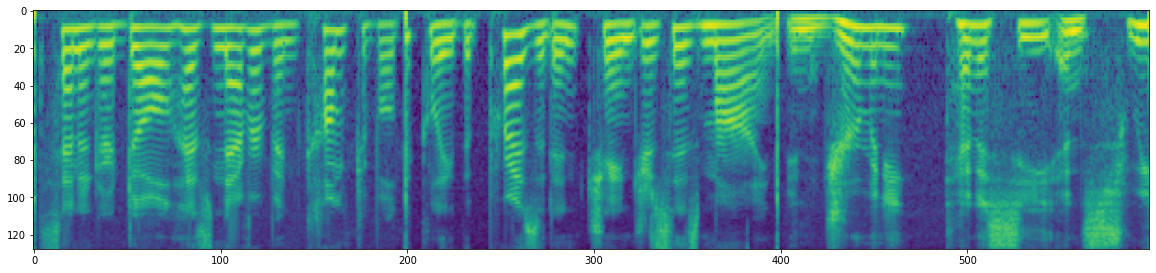

In [13]:
triplets = pd.read_csv('trainfiles/triplets.csv')
#triplets = triplets[triplets['anchor_speaker'] == 'i960711p_anchor2']
idx = np.random.randint(0, len(triplets))
triplet = triplets.iloc[idx]
anchor_segment = np.fromfile(triplet['anchor_file'], dtype = np.int16)/(2**15)
positive_segment = np.fromfile(triplet['positive_file'], dtype = np.int16)/(2**15)
negative_segment = np.fromfile(triplet['negative_file'], dtype = np.int16)/(2**15)
print(triplet)
print(anchor_segment.std())

S = librosa.feature.melspectrogram(np.concatenate((anchor_segment, positive_segment, negative_segment)), n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
plt.figure(figsize = (20, 30))
plt.imshow(S_dB)
ipd.Audio(np.concatenate((anchor_segment, positive_segment, negative_segment)), rate = sr)

(128, 399)
different


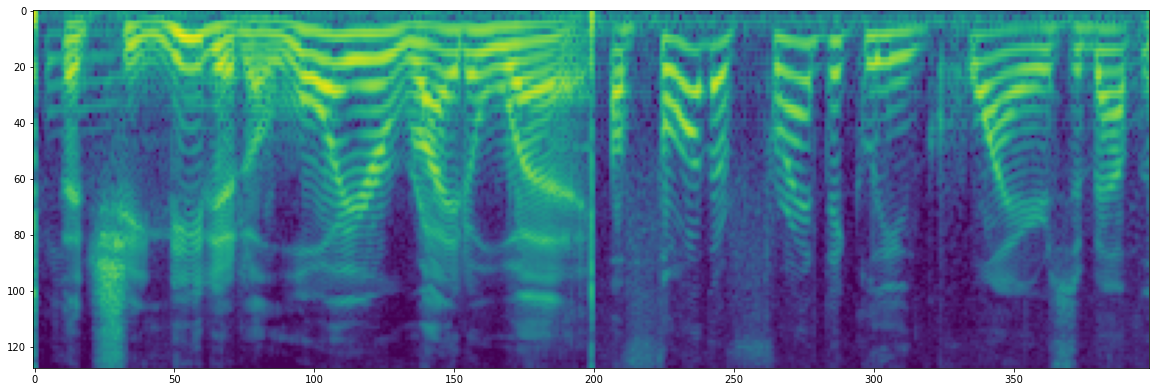

In [14]:
pairs = pd.read_csv('trainfiles/pairs.csv')
idx = np.random.randint(0, len(pairs))
pair = pairs.iloc[idx]
first_segment = np.fromfile(pair['first_file'], dtype = np.int16)/(2**15)
second_segment = np.fromfile(pair['second_file'], dtype = np.int16)/(2**15)
S = librosa.feature.melspectrogram(np.concatenate((first_segment, second_segment)), n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
plt.figure(figsize = (20, 30))
plt.imshow(S_dB)
if pair['label']:
    print('different')
else:
    print('same')
ipd.Audio(np.concatenate((first_segment, second_segment)), rate = sr)


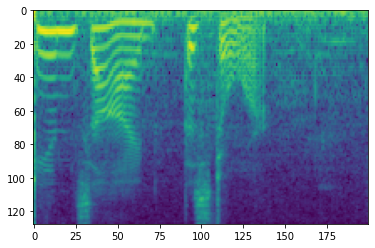

In [15]:
class TripletsDataSet(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.triplets = pd.read_csv('trainfiles/triplets.csv')
    def __len__(self):
        return len(self.triplets)
    def __getitem__(self, idx):
        triplet = self.triplets.iloc[idx]
        anchor_segment = np.fromfile(triplet['anchor_file'], dtype = np.int16)/(2**15)
        positive_segment = np.fromfile(triplet['positive_file'], dtype = np.int16)/(2**15)
        negative_segment = np.fromfile(triplet['negative_file'], dtype = np.int16)/(2**15)
        return self.make_spectrogram(anchor_segment), self.make_spectrogram(positive_segment), self.make_spectrogram(negative_segment)
    def make_spectrogram(self, segment):
        S = librosa.feature.melspectrogram(segment, n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
        S_dB = librosa.power_to_db(S, ref=np.max).T[None, :, :] # add channel dimension
        S_dB = (S_dB+40)/40
        return(S_dB)
trainset = TripletsDataSet()
class PairsDataSet(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.pairs = pd.read_csv('trainfiles/pairs.csv')
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        pair = self.pairs.iloc[idx]
        seg1 = np.fromfile(pair['first_file'], dtype = np.int16)/(2**15)
        seg2 = np.fromfile(pair['second_file'], dtype = np.int16)/(2**15)
        seg1, seg2 = self.make_spectrogram(seg1), self.make_spectrogram(seg2)
        label = pair['label']
        return (seg1, seg2), label
    def make_spectrogram(self, segment):
        S = librosa.feature.melspectrogram(segment, n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
        S_dB = librosa.power_to_db(S, ref=np.max).T[None, :, :] # add channel dimension
        S_dB = (S_dB+40)/40
        return(S_dB)
trainset_cls = PairsDataSet()

class TestSet(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.pairs = pd.read_csv('trainfiles/val-pairs.csv')
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        pair = self.pairs.iloc[idx]
        seg1 = np.fromfile(pair['first_file'], dtype = np.int16)/(2**15)
        seg2 = np.fromfile(pair['second_file'], dtype = np.int16)/(2**15)
        seg1, seg2 = self.make_spectrogram(seg1), self.make_spectrogram(seg2)
        label = pair['label']
        return (seg1, seg2), label
    def make_spectrogram(self, segment):
        S = librosa.feature.melspectrogram(segment, n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
        S_dB = librosa.power_to_db(S, ref=np.max).T[None, :, :] # add channel dimension
        S_dB = (S_dB+40)/40
        return(S_dB)
testset = TestSet()
idx = np.random.randint(len(testset))
plt.imshow(testset[idx][0][np.random.randint(2)][0].T)

## Causal version, slow, maybe try torch jit

In [16]:
class Spectral_Attention(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Spectral_Attention, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = nn.LSTM(input_size, hidden_size, num_layers, batch_first = False)
        self.attention = nn.Linear(hidden_size*num_layers, input_size) # can replace this with better attention mechanism
    def zero_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda(),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda())
    def forward(self, X, prev_state = None, mask = None): # X: (sequence length, batch, hidden size)
        batch_size = X.shape[1]
        if prev_state == None: # if we don't initialize hidden state
            prev_state = self.zero_state(batch_size)
        if mask == None:
            mask = torch.ones(batch_size, self.input_size).cuda()
        outputs = []
        for t, x in enumerate(X):
            x = x*mask
            x = x[None, ...] # 1, batch, hidden_size
            output, (state_h, state_c) = self.cell(x, prev_state)
            prev_state = (state_h, state_c)
            state_h = state_h.view(batch_size, -1)
            mask = self.attention(state_h)
            outputs.append(output)
        outputs = torch.cat(outputs, dim = 0)
        return outputs

# Reduce number of channels!!!!!!!!!!!!

## Noncausal version with Residual Attention

In [70]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels, output_channels, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        #out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

class AttentionModule_stage1(nn.Module):
    # input size is 56*56
    def __init__(self, in_channels, out_channels, size1=(200, 64), size2=(100, 32), size3=(50, 16)):
        super(AttentionModule_stage1, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = ResidualBlock(in_channels, out_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)

        self.softmax4_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax5_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        #batch_size, nheads, length, n_mels = x.shape
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x) # 100x64
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1) # 50x32
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2) # 25x16
        out_softmax3 = self.softmax3_blocks(out_mpool3) 
        out_interp3 = self.interpolation3(out_softmax3) + out_softmax2
        out = out_interp3 + out_skip2_connection
        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = self.interpolation2(out_softmax4) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = self.interpolation1(out_softmax5) + out_trunk
        out_softmax6 = self.softmax6_blocks(out_interp1)
        out = (1 + out_softmax6) * out_trunk
        out_last = self.last_blocks(out)
        return out_last

num_heads = 2 # Residual Attention Channels
num_heads_2 = 4 # MHA heads


class Siamese(nn.Module):
    def __init__(self):
        super().__init__()
        self.downsample1 = nn.Sequential(nn.Conv2d(1, num_heads, kernel_size=3, stride=(1,2), padding=1), ##downsampling
                        nn.BatchNorm2d(num_heads),
                        nn.ReLU(inplace=True))
        self.res_att = AttentionModule_stage1(num_heads, num_heads)  # batch_size * num_heads * L *128
        self.downsample2 = nn.Sequential(nn.Conv2d(num_heads, num_heads, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(num_heads),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=3, stride=(1, 2), padding=1))
        self.reshape =  Lambda(lambda x: x.permute((2, 0, 1, 3)).contiguous().view(x.shape[2], x.shape[0], -1)) # L * batch_size * (num_heads*128)
        self.lstm = nn.LSTM(num_heads*32, 32, 2, batch_first = False, bidirectional = True, dropout = dropout) # L * batch_size * 200 * n_hidden
        self.mha =  torch.nn.MultiheadAttention(64, num_heads = num_heads_2, dropout=dropout, bias=True, kdim=64, vdim=64) # L * N * 64
        self.fc = nn.Linear(64, 32)
        self.average = Lambda(lambda x: x.mean(dim = 0)) # batch * n_hidden
        self.norm = Lambda(lambda x: torch.nn.functional.normalize(x, p = 2, dim = 1)) # L2 normalize across n_hidden
    def forward(self, X):
        X = self.downsample1(X)
        #print('first downsample ', X.shape)
        X = self.res_att(X)
        #print('residual attention ', X.shape)
        X = self.downsample2(X)
        #print('second downsample ', X.shape)
        X = self.reshape(X)
        #print('reshape ', X.shape)
        X,_ = self.lstm(X)
        #print('lstm ', X.shape)
        X,_ = self.mha(X, X, X)
        #print('mha ', X.shape)
        X = self.fc(X)
        #print('dense ', X.shape)
        X = self.average(X)
        #print('mean ', X.shape)
        X = self.norm(X)
        #print('norm ', X.shape)
        return X
    
    
siamese = Siamese().cuda()
    
# tune hidden layers smaller if overfit
optimizer = torch.optim.Adam(siamese.parameters(), 0.001)

if os.path.exists('models/model.pth'):
    print('load model')
    checkpoint = torch.load('models/model.pth')
    siamese.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']

if half:
    siamese.half()  # convert to half precision
    for layer in siamese.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.float()
            
siamese.train()

load model


Siamese(
  (downsample1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res_att): AttentionModule_stage1(
    (first_residual_blocks): ResidualBlock(
      (bn1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv1): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv4): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (trunk_branches): Sequential(
      (0): ResidualBloc

## Things to try: Maybe add a multi-headed timewise attention to LSTM output? See if it focuses on attack of sounds? Actually, I can pretrain using tanh+averaging, then during classification, apply tanh+concat+MHA

## Pre-train embedding

In [74]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 0.3):
        super(TripletLoss, self).__init__()
        self.margin = margin
    def forward(self, anchor, positive, negative, size_average=True):
        # anchor - positive shape is batch_size * n_embedding
        distance_positive = (anchor - positive).pow(2).sum(1).pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1).pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, pin_memory = True, num_workers = 8)
criterion = TripletLoss()
lasttime = time.time()


for epoch in range(6):
    running_loss = 0.0
    for batch_idx, (X_anchor, X_pos, X_neg) in enumerate(trainloader):
        optimizer.zero_grad()
        if half:
            X_anchor, X_pos, X_neg = X_anchor.half(), X_pos.half(), X_neg.half()
        X_anchor, X_pos, X_neg = X_anchor.cuda(), X_pos.cuda(), X_neg.cuda()
        out_anchor, out_pos, out_neg = siamese(X_anchor), siamese(X_pos), siamese(X_neg)
        loss = criterion(out_anchor, out_pos, out_neg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(siamese.parameters(), 0.5)
        optimizer.step()



        running_loss += loss.item()
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 200))
            running_loss = 0.0
            torch.save({
            'model_state_dict': siamese.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'models/model.pth')
        #measure time
        #print('batch time: ', str(time.time()-lasttime)[:4])
        lasttime = time.time()


[1,   200] loss: 0.043
[1,   400] loss: 0.037
[1,   600] loss: 0.036
[1,   800] loss: 0.035
[1,  1000] loss: 0.034
[1,  1200] loss: 0.033
[1,  1400] loss: 0.032
[1,  1600] loss: 0.032
[1,  1800] loss: 0.033
[1,  2000] loss: 0.031
[1,  2200] loss: 0.034
[1,  2400] loss: 0.032
[1,  2600] loss: 0.032
[1,  2800] loss: 0.030
[1,  3000] loss: 0.032
[1,  3200] loss: 0.029
[1,  3400] loss: 0.032
[1,  3600] loss: 0.029
[1,  3800] loss: 0.029
[1,  4000] loss: 0.029
[1,  4200] loss: 0.030
[1,  4400] loss: 0.030
[1,  4600] loss: 0.027
[1,  4800] loss: 0.027
[1,  5000] loss: 0.027
[1,  5200] loss: 0.029
[1,  5400] loss: 0.028
[1,  5600] loss: 0.030
[1,  5800] loss: 0.026
[1,  6000] loss: 0.027
[1,  6200] loss: 0.028
[1,  6400] loss: 0.027
[1,  6600] loss: 0.028
[2,   200] loss: 0.022
[2,   400] loss: 0.023
[2,   600] loss: 0.026
[2,   800] loss: 0.025
[2,  1000] loss: 0.027
[2,  1200] loss: 0.024
[2,  1400] loss: 0.026
[2,  1600] loss: 0.027
[2,  1800] loss: 0.023
[2,  2000] loss: 0.023
[2,  2200] 

## Train Classifier ##
# Add Dropout

In [75]:
class Classifier(nn.Module):
    def __init__(self, siamese):
        super().__init__()
        self.siamese = siamese
        self.fc1 = nn.Sequential(nn.Dropout(0.0), nn.Linear(64, 64), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Dropout(0.0), nn.Linear(64, 64), nn.ReLU())
        self.out = nn.Sequential(nn.Dropout(0.0), nn.Linear(64, 1)) # sigmoid is in loss
    def forward(self, x1, x2):
        embedding_1 = self.siamese(x1) # batch_size * n_embedding
        embedding_2 = self.siamese(x2) # batch_size * n_embedding
        x = torch.cat([embedding_1, embedding_2], dim = 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x).view(x1.shape[0])

cls = Classifier(siamese).cuda()
optimizer = torch.optim.Adam(cls.parameters(), 0.001)

if os.path.exists('models/cls.pth'):
    print('load model')
    checkpoint = torch.load('models/cls.pth')
    cls.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']

if half:
    cls.half()  # convert to half precision
    for layer in cls.modules():
        if isinstance(layer, nn.BatchNorm2d):
            cls.float()
cls.train()



Classifier(
  (siamese): Siamese(
    (downsample1): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1))
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (res_att): AttentionModule_stage1(
      (first_residual_blocks): ResidualBlock(
        (bn1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv1): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv4): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )


In [76]:
trainloader_cls = torch.utils.data.DataLoader(trainset_cls, batch_size=32, shuffle=True, pin_memory = True, num_workers = 8)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, pin_memory = True, num_workers = 8)
criterion = nn.BCEWithLogitsLoss()
lasttime = time.time()

for epoch in range(16):
    running_loss = 0.0
    running_accuracy = 0.0
    for batch_idx, ((X_1, X_2), label) in enumerate(trainloader_cls):
        optimizer.zero_grad()
        if half:
            X_1, X_2 = X_1.half(), X_2.half()
        X_1, X_2, label = X_1.cuda(), X_2.cuda(), label.cuda()
        out = cls(X_1, X_2)
        label = label.float()
        loss = criterion(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cls.parameters(), 0.5)
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += sum((out.data.cpu().numpy()>0) == label.data.cpu().numpy())/32
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200, running_accuracy / 200))
            running_loss = 0.0
            running_accuracy = 0.0
            torch.save({
            'model_state_dict': cls.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'models/cls.pth')
    
    
    
    corrects = 0
    for batch_idx, ((X_1, X_2), label) in enumerate(testloader):
        if half:
            X_1, X_2 = X_1.half(), X_2.half()
        else:
            X_1, X_2 = X_1.float(), X_2.float()
        X_1, X_2, label = X_1.cuda(), X_2.cuda(), label.cuda()
        cls.eval()
        out = cls(X_1, X_2)
        label = label.float()
        corrects += sum((out.data.cpu().numpy()>0) == label.data.cpu().numpy())
    print(corrects/len(testset))
    if corrects/len(testset) > 0.85:
        torch.save({
        'model_state_dict': cls.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
        }, 'models/best-baseline-cls.pth')
    cls.train()
            

[1,   200] loss: 0.576 accuracy: 0.692
[1,   400] loss: 0.435 accuracy: 0.802
[1,   600] loss: 0.327 accuracy: 0.866
[1,   800] loss: 0.291 accuracy: 0.885
[1,  1000] loss: 0.277 accuracy: 0.888
[1,  1200] loss: 0.254 accuracy: 0.898
[1,  1400] loss: 0.241 accuracy: 0.907
[1,  1600] loss: 0.234 accuracy: 0.910
[1,  1800] loss: 0.228 accuracy: 0.909
[1,  2000] loss: 0.223 accuracy: 0.912
[1,  2200] loss: 0.222 accuracy: 0.914
[1,  2400] loss: 0.222 accuracy: 0.914
[1,  2600] loss: 0.220 accuracy: 0.909
[1,  2800] loss: 0.205 accuracy: 0.920
[1,  3000] loss: 0.204 accuracy: 0.921
[1,  3200] loss: 0.216 accuracy: 0.915
[1,  3400] loss: 0.194 accuracy: 0.924
[1,  3600] loss: 0.202 accuracy: 0.923
[1,  3800] loss: 0.181 accuracy: 0.931
[1,  4000] loss: 0.186 accuracy: 0.928
[1,  4200] loss: 0.194 accuracy: 0.925
[1,  4400] loss: 0.195 accuracy: 0.924
[1,  4600] loss: 0.186 accuracy: 0.926
[1,  4800] loss: 0.194 accuracy: 0.925
[1,  5000] loss: 0.193 accuracy: 0.931
[1,  5200] loss: 0.189 ac

0.9415036784496681
[4,   200] loss: 0.116 accuracy: 0.960
[4,   400] loss: 0.104 accuracy: 0.963
[4,   600] loss: 0.116 accuracy: 0.961
[4,   800] loss: 0.119 accuracy: 0.957
[4,  1000] loss: 0.114 accuracy: 0.960
[4,  1200] loss: 0.112 accuracy: 0.960
[4,  1400] loss: 0.114 accuracy: 0.962
[4,  1600] loss: 0.108 accuracy: 0.964
[4,  1800] loss: 0.122 accuracy: 0.956
[4,  2000] loss: 0.112 accuracy: 0.963
[4,  2200] loss: 0.119 accuracy: 0.960
[4,  2400] loss: 0.112 accuracy: 0.962
[4,  2600] loss: 0.120 accuracy: 0.957
[4,  2800] loss: 0.111 accuracy: 0.961
[4,  3000] loss: 0.128 accuracy: 0.957
[4,  3200] loss: 0.114 accuracy: 0.962
[4,  3400] loss: 0.112 accuracy: 0.958
[4,  3600] loss: 0.120 accuracy: 0.959
[4,  3800] loss: 0.108 accuracy: 0.961
[4,  4000] loss: 0.118 accuracy: 0.958
[4,  4200] loss: 0.123 accuracy: 0.957
[4,  4400] loss: 0.136 accuracy: 0.953
[4,  4600] loss: 0.112 accuracy: 0.963
[4,  4800] loss: 0.110 accuracy: 0.965
[4,  5000] loss: 0.110 accuracy: 0.962
[4,  5

[6, 14000] loss: 0.095 accuracy: 0.967
0.9429092649081883
[7,   200] loss: 0.091 accuracy: 0.968
[7,   400] loss: 0.089 accuracy: 0.969
[7,   600] loss: 0.093 accuracy: 0.968
[7,   800] loss: 0.093 accuracy: 0.970
[7,  1000] loss: 0.101 accuracy: 0.966
[7,  1200] loss: 0.093 accuracy: 0.969
[7,  1400] loss: 0.094 accuracy: 0.970
[7,  1600] loss: 0.096 accuracy: 0.965
[7,  1800] loss: 0.096 accuracy: 0.968
[7,  2000] loss: 0.092 accuracy: 0.969
[7,  2200] loss: 0.094 accuracy: 0.969
[7,  2400] loss: 0.097 accuracy: 0.966
[7,  2600] loss: 0.091 accuracy: 0.970
[7,  2800] loss: 0.084 accuracy: 0.971
[7,  3000] loss: 0.097 accuracy: 0.966
[7,  3200] loss: 0.082 accuracy: 0.972
[7,  3400] loss: 0.095 accuracy: 0.969
[7,  3600] loss: 0.095 accuracy: 0.968
[7,  3800] loss: 0.094 accuracy: 0.967
[7,  4000] loss: 0.089 accuracy: 0.971
[7,  4200] loss: 0.092 accuracy: 0.970
[7,  4400] loss: 0.101 accuracy: 0.967
[7,  4600] loss: 0.091 accuracy: 0.969
[7,  4800] loss: 0.090 accuracy: 0.968
[7,  5

[9, 13800] loss: 0.071 accuracy: 0.975
[9, 14000] loss: 0.076 accuracy: 0.974
0.9454213768766074
[10,   200] loss: 0.076 accuracy: 0.973
[10,   400] loss: 0.070 accuracy: 0.976
[10,   600] loss: 0.087 accuracy: 0.971
[10,   800] loss: 0.087 accuracy: 0.971
[10,  1000] loss: 0.072 accuracy: 0.977
[10,  1200] loss: 0.073 accuracy: 0.977
[10,  1400] loss: 0.084 accuracy: 0.972
[10,  1600] loss: 0.078 accuracy: 0.973
[10,  1800] loss: 0.078 accuracy: 0.976
[10,  2000] loss: 0.077 accuracy: 0.975
[10,  2200] loss: 0.077 accuracy: 0.975
[10,  2400] loss: 0.077 accuracy: 0.976
[10,  2600] loss: 0.082 accuracy: 0.973
[10,  2800] loss: 0.081 accuracy: 0.974
[10,  3000] loss: 0.078 accuracy: 0.974
[10,  3200] loss: 0.075 accuracy: 0.976
[10,  3400] loss: 0.070 accuracy: 0.977
[10,  3600] loss: 0.081 accuracy: 0.975
[10,  3800] loss: 0.089 accuracy: 0.971
[10,  4000] loss: 0.086 accuracy: 0.971
[10,  4200] loss: 0.076 accuracy: 0.976
[10,  4400] loss: 0.069 accuracy: 0.977
[10,  4600] loss: 0.077

[12, 12600] loss: 0.076 accuracy: 0.975
[12, 12800] loss: 0.079 accuracy: 0.975
[12, 13000] loss: 0.072 accuracy: 0.975
[12, 13200] loss: 0.080 accuracy: 0.973
[12, 13400] loss: 0.070 accuracy: 0.978
[12, 13600] loss: 0.069 accuracy: 0.977
[12, 13800] loss: 0.075 accuracy: 0.975
[12, 14000] loss: 0.071 accuracy: 0.977
0.9518810933668281
[13,   200] loss: 0.064 accuracy: 0.979
[13,   400] loss: 0.068 accuracy: 0.977
[13,   600] loss: 0.073 accuracy: 0.977
[13,   800] loss: 0.068 accuracy: 0.977
[13,  1000] loss: 0.066 accuracy: 0.978
[13,  1200] loss: 0.069 accuracy: 0.977
[13,  1400] loss: 0.066 accuracy: 0.980
[13,  1600] loss: 0.070 accuracy: 0.978
[13,  1800] loss: 0.071 accuracy: 0.977
[13,  2000] loss: 0.068 accuracy: 0.978
[13,  2200] loss: 0.069 accuracy: 0.977
[13,  2400] loss: 0.071 accuracy: 0.978
[13,  2600] loss: 0.068 accuracy: 0.978
[13,  2800] loss: 0.074 accuracy: 0.976
[13,  3000] loss: 0.064 accuracy: 0.977
[13,  3200] loss: 0.079 accuracy: 0.975
[13,  3400] loss: 0.0

[15, 11400] loss: 0.061 accuracy: 0.979
[15, 11600] loss: 0.064 accuracy: 0.980
[15, 11800] loss: 0.065 accuracy: 0.978
[15, 12000] loss: 0.066 accuracy: 0.979
[15, 12200] loss: 0.057 accuracy: 0.984
[15, 12400] loss: 0.073 accuracy: 0.977
[15, 12600] loss: 0.075 accuracy: 0.976
[15, 12800] loss: 0.076 accuracy: 0.975
[15, 13000] loss: 0.063 accuracy: 0.981
[15, 13200] loss: 0.073 accuracy: 0.976
[15, 13400] loss: 0.072 accuracy: 0.976
[15, 13600] loss: 0.068 accuracy: 0.979
[15, 13800] loss: 0.061 accuracy: 0.980
[15, 14000] loss: 0.070 accuracy: 0.978
0.9461989353430229
[16,   200] loss: 0.058 accuracy: 0.981
[16,   400] loss: 0.061 accuracy: 0.980
[16,   600] loss: 0.061 accuracy: 0.980
[16,   800] loss: 0.068 accuracy: 0.978
[16,  1000] loss: 0.062 accuracy: 0.979
[16,  1200] loss: 0.064 accuracy: 0.979
[16,  1400] loss: 0.058 accuracy: 0.981
[16,  1600] loss: 0.062 accuracy: 0.981
[16,  1800] loss: 0.072 accuracy: 0.977
[16,  2000] loss: 0.062 accuracy: 0.980
[16,  2200] loss: 0.0

In [24]:
modulelist = list(cls.siamese.modules())
extractor = nn.Sequential(*modulelist[1:5])

<Figure size 432x288 with 0 Axes>

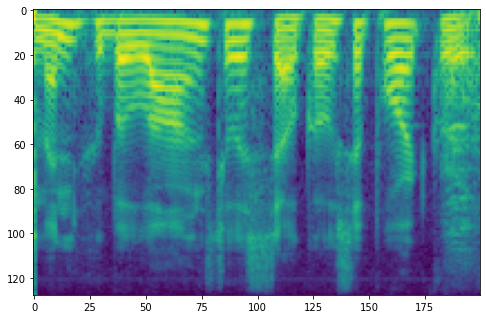

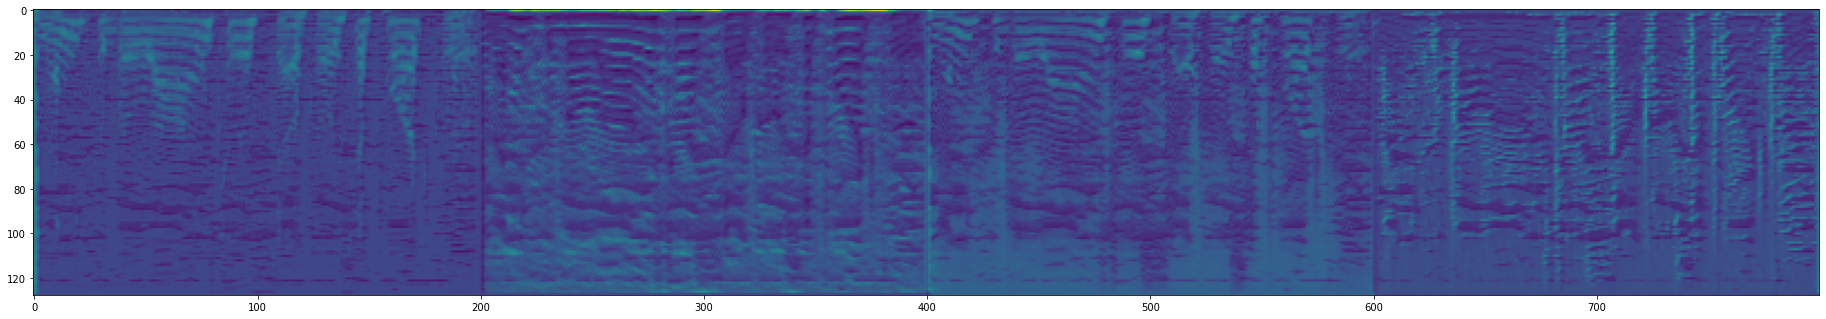

In [25]:
out = extractor(X_1[0:1])[0].detach().cpu().numpy()
out = out.reshape(-1, out.shape[-1])
plt.figure()
plt.figure(figsize = (8, 8))
plt.imshow(X_1[0][0].detach().cpu().numpy().T)
plt.figure(figsize = (32, 8))
plt.imshow(out.T)

NameError: name 'label' is not defined

## Use both TDP and IFP